
# Sentiment Analysis on Product Reviews
**Goal:** Determine whether a review's sentiment is **positive** or **negative**.

**Features:**
- Clean & preprocess text (lowercasing, URL/punctuation/number removal, stopwords)
- Optional **lemmatization** (spaCy preferred; fallback to NLTK WordNet)
- Text → **TF‑IDF** (default) or **CountVectorizer**
- Train **Logistic Regression** and **Multinomial Naive Bayes** (compare accuracy)
- **Evaluation**: accuracy, classification report, confusion matrix
- **Visualizations**: most frequent **positive/negative** words (bar charts) + **word clouds**

> **Dataset used:** a CSV file named `reviews.csv` in the same folder, with:
> - a text column: `review` (or `text`, `review_text`)
> - a binary label column: `sentiment` (1=positive, 0=negative) or `label`/`polarity` (with values like 0/1 or negative/positive)


## 1. Environment Setup

In [ ]:

# If needed, uncomment to install locally:
# %pip install numpy pandas scikit-learn nltk spacy wordcloud matplotlib
# python -m spacy download en_core_web_sm


## 2. Imports & Resource Setup

In [ ]:

import os, re, string, warnings, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Visualization defaults
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from wordcloud import WordCloud

# NLTK & spaCy setup
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Ensure NLTK resources are available
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

# spaCy
USE_SPACY = True
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    except Exception:
        # If model not present, try to load blank English model as fallback
        nlp = spacy.blank("en")
except Exception:
    USE_SPACY = False
    nlp = None
    warnings.warn("spaCy isn't available; falling back to NLTK WordNet for lemmatization.")

print("spaCy available:", bool(nlp))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Youssef\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Youssef\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Youssef\AppData\Roaming\nltk_data...


spaCy available: True


## 3. Load Dataset

In [ ]:
# Tries to auto-detect common text/label column names and normalize labels to 0/1.

def load_reviews(csv_path="./datasets/IMDB_Dataset.csv"):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(
            f"Could not find {csv_path}. Please put your dataset CSV (IMDb/Amazon/Kaggle) there."
        )
    df = pd.read_csv(csv_path)

    # Candidate text/label columns
    text_cols = [c for c in df.columns if c.lower() in ["review", "text", "review_text", "content", "body"]]
    label_cols = [c for c in df.columns if c.lower() in ["sentiment", "label", "polarity", "target"]]

    if not text_cols:
        raise ValueError("No text column found. Add a column named 'review' (or 'text', 'review_text').")
    if not label_cols:
        raise ValueError("No label column found. Add 'sentiment' (or 'label', 'polarity', 'target').")

    text_col = text_cols[0]
    label_col = label_cols[0]

    df = df[[text_col, label_col]].rename(columns={text_col: "review", label_col: "sentiment"}).dropna()

    # Normalize labels to binary 0/1
    def normalize_label(v):
        if isinstance(v, str):
            v_low = v.strip().lower()
            if v_low in ["pos", "positive", "1", "true", "t", "yes", "y"]:
                return 1
            if v_low in ["neg", "negative", "0", "false", "f", "no", "n"]:
                return 0
        # numeric-like
        try:
            f = float(v)
            return int(f >= 0.5)  # if labels are probabilities or 0/1
        except Exception:
            pass
        raise ValueError(f"Unrecognized label value: {v}. Expected positive/negative or 0/1.")

    df["sentiment"] = df["sentiment"].apply(normalize_label).astype(int)
    return df

df = load_reviews("./datasets/IMDB_Dataset.csv")
print(df.head())
print("\nClass balance:\n", df['sentiment'].value_counts())


                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1

Class balance:
 sentiment
1    25000
0    25000
Name: count, dtype: int64


## 4. Clean & Preprocess Text

In [3]:

# Build stopword list and preserve negations
stop_words = set(stopwords.words("english"))
negation_keep = {"no", "nor", "not", "n't", "never"}
stop_words = {w for w in stop_words if w not in negation_keep}

wnl = WordNetLemmatizer()

URL_RE = re.compile(r"https?://\S+|www\.\S+")
HTML_RE = re.compile(r"<.*?>")
PUNCT_TABLE = str.maketrans('', '', string.punctuation)

def lemmatize_tokens(tokens):
    if nlp:  # spaCy branch
        doc = nlp(" ".join(tokens))
        return [t.lemma_ for t in doc]
    # NLTK WordNet fallback
    return [wnl.lemmatize(t) for t in tokens]

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = URL_RE.sub(" ", text)
    text = HTML_RE.sub(" ", text)
    text = text.translate(PUNCT_TABLE)
    text = re.sub(r"\d+", " ", text)  # remove digits
    tokens = [tok for tok in text.split() if tok.isalpha()]
    # Lemmatize then remove stopwords (preserve negations)
    tokens = lemmatize_tokens(tokens)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

# Apply cleaning
df["cleaned_review"] = df["review"].astype(str).apply(clean_text)
print(df[["review", "cleaned_review", "sentiment"]].head())


                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  sentiment  
0  one reviewer mention watch oz episode hook rig...          1  
1  wonderful little production filming technique ...          1  
2  think wonderful way spend time hot summer week...          1  
3  basically family little boy jake think zombie ...          0  
4  petter matteis love time money visually stunni...          1  


## 5. Split & Vectorize (TF‑IDF by default, Count optional)

In [4]:

from typing import Literal

VECTORIZER: Literal["tfidf", "count"] = "tfidf"  # change to "count" to use CountVectorizer

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["cleaned_review"], df["sentiment"], test_size=0.2, random_state=42, stratify=df["sentiment"]
)

if VECTORIZER == "tfidf":
    vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), max_df=0.9, min_df=2)
else:
    vectorizer = CountVectorizer(max_features=20000, ngram_range=(1,2), max_df=0.9, min_df=2)

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

print(VECTORIZER.upper(), "vectorizer fitted.")
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


TFIDF vectorizer fitted.
Train shape: (40000, 20000) | Test shape: (10000, 20000)


## 6. Train Models (Logistic Regression + Naive Bayes)

In [5]:

# Logistic Regression with simple hyperparameter search
lr = LogisticRegression(max_iter=1000, solver="liblinear")
param_grid = {
    "C": [0.1, 1.0, 3.0, 10.0],
    "penalty": ["l1", "l2"],  # liblinear supports l1/l2
}
grid = GridSearchCV(lr, param_grid=param_grid, cv=5, n_jobs=-1, scoring="accuracy", verbose=0)
grid.fit(X_train, y_train)
best_lr = grid.best_estimator_

# Naive Bayes (Multinomial)
nb = MultinomialNB()
nb.fit(X_train, y_train)

print("Best LR params:", grid.best_params_)


Best LR params: {'C': 3.0, 'penalty': 'l2'}


## 7. Evaluation

Logistic Regression Accuracy: 0.9054

              precision    recall  f1-score   support

    Negative       0.91      0.90      0.90      5000
    Positive       0.90      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Naive Bayes Accuracy: 0.8763

              precision    recall  f1-score   support

    Negative       0.89      0.86      0.87      5000
    Positive       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Accuracy Comparison -> LR: 0.9054 | NB: 0.8763


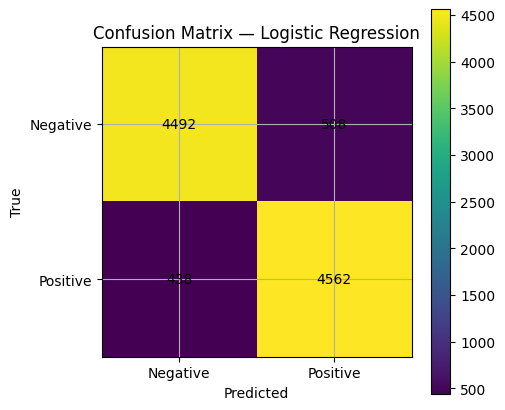

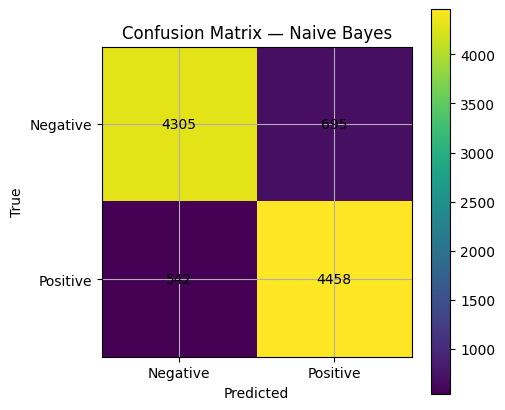

In [6]:

def evaluate_model(name, clf, X_te, y_te):
    preds = clf.predict(X_te)
    acc = accuracy_score(y_te, preds)
    print(f"{name} Accuracy: {acc:.4f}\n")
    print(classification_report(y_te, preds, target_names=["Negative", "Positive"]))
    return preds, acc

y_pred_lr, lr_acc = evaluate_model("Logistic Regression", best_lr, X_test, y_test)
y_pred_nb, nb_acc = evaluate_model("Naive Bayes", nb, X_test, y_test)

print(f"\nAccuracy Comparison -> LR: {lr_acc:.4f} | NB: {nb_acc:.4f}")

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    cax = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Negative','Positive']); ax.set_yticklabels(['Negative','Positive'])
    # Annotate cells
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val}", ha='center', va='center')
    fig.colorbar(cax)
    plt.show()

plot_confusion(y_test, y_pred_lr, "Confusion Matrix — Logistic Regression")
plot_confusion(y_test, y_pred_nb, "Confusion Matrix — Naive Bayes")


## 8. Visualize Most Frequent Positive & Negative Words

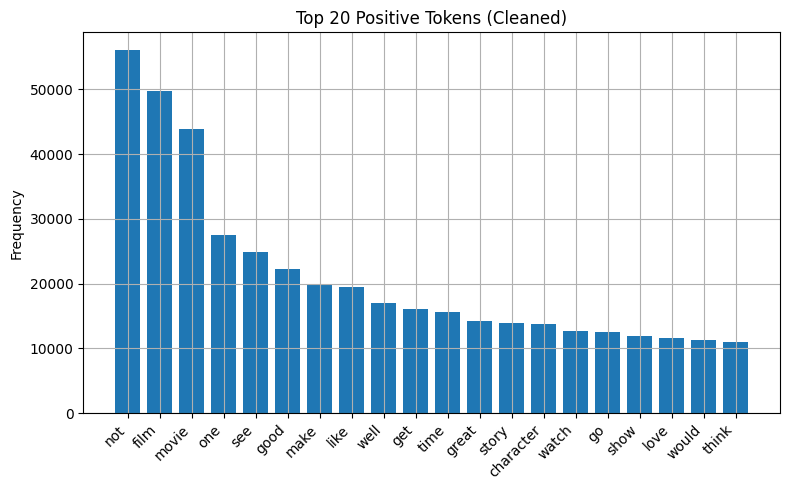

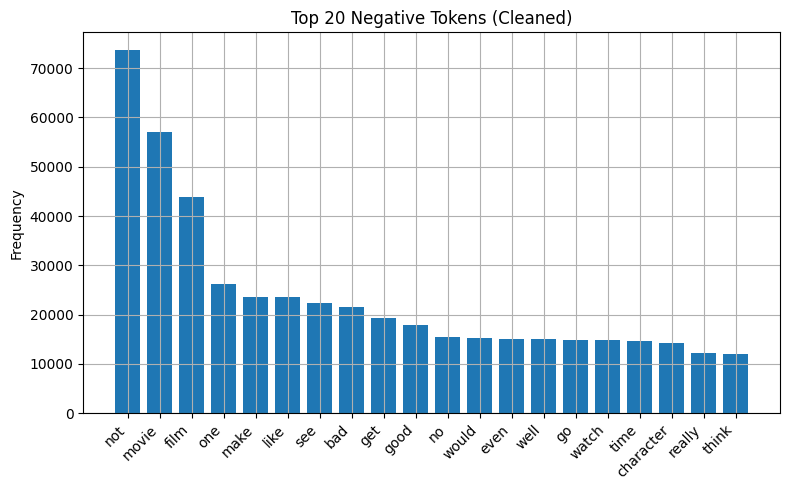

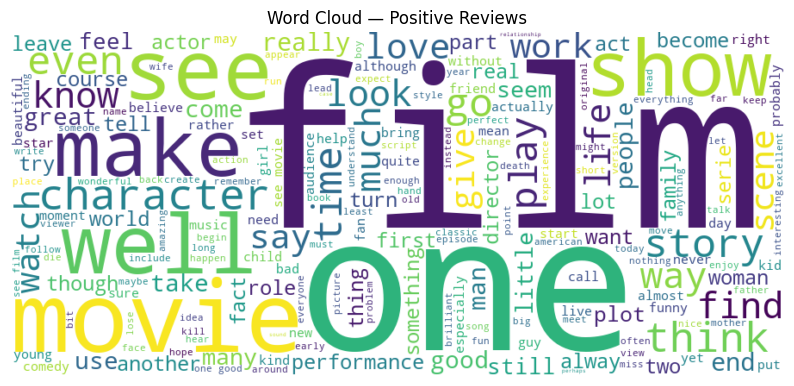

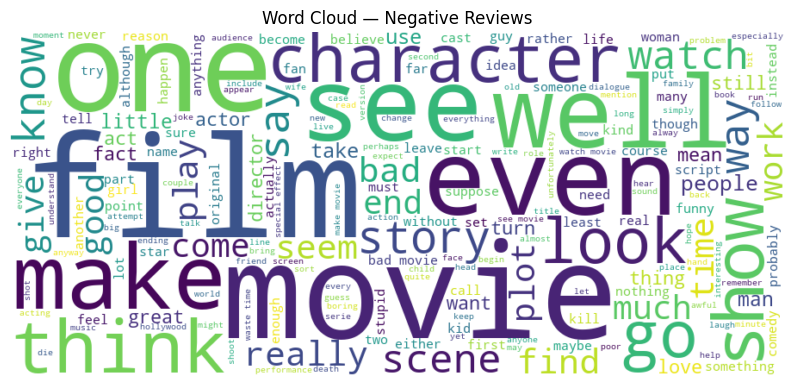

In [7]:

# Token frequency per class from cleaned text
def top_tokens_by_class(df, label, k=20):
    text = " ".join(df.loc[df["sentiment"]==label, "cleaned_review"])
    tokens = text.split()
    freq = Counter(tokens)
    return freq.most_common(k)

top_pos = top_tokens_by_class(df, 1, k=20)
top_neg = top_tokens_by_class(df, 0, k=20)

def plot_top_bar(items, title):
    tokens, counts = zip(*items) if items else ([], [])
    fig, ax = plt.subplots()
    ax.bar(range(len(tokens)), counts)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_title(title)
    ax.set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_top_bar(top_pos, "Top 20 Positive Tokens (Cleaned)")
plot_top_bar(top_neg, "Top 20 Negative Tokens (Cleaned)")

# Word Clouds
def plot_wordcloud_for_label(df, label, title):
    text = " ".join(df.loc[df["sentiment"]==label, "cleaned_review"])
    if not text.strip():
        print("No text available for this label to build a word cloud.")
        return
    wc = WordCloud(width=900, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud_for_label(df, 1, "Word Cloud — Positive Reviews")
plot_wordcloud_for_label(df, 0, "Word Cloud — Negative Reviews")


## 9. Most Informative Features (Logistic Regression)

In [8]:

# Inspect most discriminative features learned by Logistic Regression
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = best_lr.coef_.ravel()

def show_top_features(coefs, feature_names, top_k=20):
    top_pos_idx = np.argsort(coefs)[-top_k:][::-1]
    top_neg_idx = np.argsort(coefs)[:top_k]
    print("Top Positive Features:")
    for idx in top_pos_idx:
        print(f"{feature_names[idx]:<25} {coefs[idx]:.4f}")
    print("\nTop Negative Features:")
    for idx in top_neg_idx:
        print(f"{feature_names[idx]:<25} {coefs[idx]:.4f}")

show_top_features(coefs, feature_names, top_k=20)


Top Positive Features:
excellent                 8.9234
great                     8.8493
perfect                   7.3545
amazing                   6.7157
hilarious                 6.2994
wonderful                 6.1310
good                      5.8470
enjoy                     5.7213
fun                       5.5657
favorite                  5.5512
brilliant                 5.4389
enjoyable                 5.2704
love                      5.1799
superb                    5.1665
must see                  5.1659
today                     5.1420
well worth                5.1226
funniest                  4.7485
one good                  4.7055
definitely                4.6692

Top Negative Features:
bad                       -13.2902
awful                     -10.5142
waste                     -10.0544
boring                    -8.0813
poor                      -7.5334
terrible                  -7.1858
fail                      -7.0750
disappointing             -6.7364
not recommend     


## 11. Test Models


In [1]:
# Streamlit test app builder: save models and create a simple UI app (CSV + PDF/TXT/DOCX + compare both models)
import os
from pathlib import Path
import joblib

ART_DIR = Path("sentiment_artifacts")
ART_DIR.mkdir(exist_ok=True)

# Save artifacts only if they exist in this session
if all(v in globals() for v in ["vectorizer", "best_lr", "nb"]):
    joblib.dump(vectorizer, ART_DIR / "vectorizer.joblib")
    joblib.dump(best_lr, ART_DIR / "logreg.joblib")
    joblib.dump(nb, ART_DIR / "naive_bayes.joblib")
    print("Artifacts saved to:", ART_DIR.resolve())
else:
    print("Artifacts not found in memory. Skipped saving models. Run training cells first if needed.")

app_code = r'''
import os, re, io, string, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import streamlit as st
import joblib

# Optional readers
try:
    import pdfplumber
except Exception:
    pdfplumber = None
try:
    from PyPDF2 import PdfReader
except Exception:
    PdfReader = None
try:
    from docx import Document  # python-docx
except Exception:
    Document = None

# ========== Load Artifacts ==========
ARTS = Path(__file__).parent / "sentiment_artifacts"
vectorizer = joblib.load(ARTS / "vectorizer.joblib")
lr = joblib.load(ARTS / "logreg.joblib")
nb = joblib.load(ARTS / "naive_bayes.joblib")

# ========== Cleaning (mirrors training) ==========
USE_SPACY = True
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    except Exception:
        nlp = spacy.blank("en")
except Exception:
    USE_SPACY = False
    nlp = None
    warnings.warn("spaCy unavailable; falling back to NLTK where possible.")

# NLTK stopwords + WordNet (with graceful fallback)
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet'); nltk.download('omw-1.4')
    stop_words = set(stopwords.words("english"))
    negation_keep = {"no", "nor", "not", "n't", "never"}
    stop_words = {w for w in stop_words if w not in negation_keep}
    wnl = WordNetLemmatizer()
except Exception:
    stop_words = set()
    wnl = None

URL_RE = re.compile(r"https?://\S+|www\.\S+")
HTML_RE = re.compile(r"<.*?>")
PUNCT_TABLE = str.maketrans('', '', string.punctuation)

def lemmatize_tokens(tokens):
    if nlp:
        doc = nlp(" ".join(tokens))
        return [t.lemma_ for t in doc]
    if wnl:
        return [wnl.lemmatize(t) for t in tokens]
    return tokens

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = URL_RE.sub(" ", text)
    text = HTML_RE.sub(" ", text)
    text = text.translate(PUNCT_TABLE)
    text = re.sub(r"\d+", " ", text)
    tokens = [tok for tok in text.split() if tok.isalpha()]
    tokens = lemmatize_tokens(tokens)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

# ========== File readers ==========

def read_txt(file) -> str:
    try:
        data = file.read()
        if isinstance(data, bytes):
            return data.decode('utf-8', errors='ignore')
        return str(data)
    finally:
        try:
            file.seek(0)
        except Exception:
            pass

def read_pdf(file) -> str:
    # Try pdfplumber first
    try:
        if pdfplumber is not None:
            with pdfplumber.open(file) as pdf:
                pages_text = [p.extract_text() or "" for p in pdf.pages]
            return "\n".join(pages_text)
    except Exception:
        try:
            file.seek(0)
        except Exception:
            pass
    # Fallback to PyPDF2
    try:
        if PdfReader is not None:
            reader = PdfReader(file)
            pages = []
            for page in reader.pages:
                try:
                    pages.append(page.extract_text() or "")
                except Exception:
                    pages.append("")
            return "\n".join(pages)
    except Exception:
        pass
    return ""

def read_docx(file) -> str:
    if Document is None:
        return ""
    try:
        doc = Document(file)
        return "\n".join(p.text for p in doc.paragraphs)
    except Exception:
        return ""

# ========== Inference ==========

def predict_both(text: str):
    x = vectorizer.transform([clean_text(text)])
    prob_lr = float(lr.predict_proba(x)[0][1])
    prob_nb = float(nb.predict_proba(x)[0][1])
    return prob_lr, prob_nb

# ========== UI ==========

st.set_page_config(page_title="Sentiment Analysis", page_icon="💬", layout="centered")
st.title("Sentiment Analysis")

with st.sidebar:
    st.header("Settings")
    compare = st.checkbox("Compare both models", value=True)
    model_choice = st.radio("Model", ["Logistic Regression", "Naive Bayes"], index=0, disabled=compare)
    threshold = st.slider("Decision threshold", 0.1, 0.9, 0.5, 0.05)

single_tab, batch_tab, files_tab = st.tabs(["Single Text", "Batch CSV", "Files (PDF/TXT/DOCX)"]) 

with single_tab:
    txt = st.text_area("Enter a review", height=160, placeholder="Type or paste a product/movie review…")
    if st.button("Predict Sentiment", type="primary", use_container_width=True):
        if not txt.strip():
            st.warning("Please enter some text.")
        else:
            p_lr, p_nb = predict_both(txt)
            if compare:
                col1, col2 = st.columns(2)
                with col1:
                    st.subheader("Logistic Regression")
                    st.write(f"Positive: {p_lr:.3f} — Negative: {1-p_lr:.3f}")
                    st.progress(p_lr)
                    st.write("Label:", "Positive" if p_lr >= threshold else "Negative")
                with col2:
                    st.subheader("Naive Bayes")
                    st.write(f"Positive: {p_nb:.3f} — Negative: {1-p_nb:.3f}")
                    st.progress(p_nb)
                    st.write("Label:", "Positive" if p_nb >= threshold else "Negative")
            else:
                if model_choice == "Logistic Regression":
                    label = "Positive" if p_lr >= threshold else "Negative"
                    st.subheader(f"Prediction: {label}")
                    st.write(f"Probability Positive: {p_lr:.3f} — Negative: {1-p_lr:.3f}")
                    st.progress(p_lr)
                else:
                    label = "Positive" if p_nb >= threshold else "Negative"
                    st.subheader(f"Prediction: {label}")
                    st.write(f"Probability Positive: {p_nb:.3f} — Negative: {1-p_nb:.3f}")
                    st.progress(p_nb)

with batch_tab:
    st.write("Upload a CSV with a column named 'review' (or 'text'/'review_text').")
    file = st.file_uploader("CSV file", type=["csv"]) 
    if file is not None:
        try:
            df = pd.read_csv(file)
        except Exception as e:
            st.error(f"Failed to read CSV: {e}")
            df = None
        if df is not None:
            cand_cols = [c for c in df.columns if c.lower() in ["review","text","review_text","content","body"]]
            if not cand_cols:
                st.error("No review text column found. Add a 'review' column.")
            else:
                col = cand_cols[0]
                cleaned = df[col].astype(str).apply(clean_text)
                X = vectorizer.transform(cleaned)
                proba_lr = lr.predict_proba(X)[:, 1]
                proba_nb = nb.predict_proba(X)[:, 1]
                if compare:
                    out = df.copy()
                    out["LR_proba_pos"] = proba_lr
                    out["LR_label"] = np.where(out["LR_proba_pos"]>=threshold, "Positive", "Negative")
                    out["NB_proba_pos"] = proba_nb
                    out["NB_label"] = np.where(out["NB_proba_pos"]>=threshold, "Positive", "Negative")
                    st.write("Preview:")
                    st.dataframe(out.head(20))
                    st.write("Counts (LR):", out["LR_label"].value_counts())
                    st.write("Counts (NB):", out["NB_label"].value_counts())
                    st.download_button(
                        "Download predictions CSV",
                        out.to_csv(index=False).encode("utf-8"),
                        file_name="sentiment_predictions_compare.csv",
                        mime="text/csv",
                    )
                else:
                    clf = lr if model_choice == "Logistic Regression" else nb
                    proba = proba_lr if model_choice == "Logistic Regression" else proba_nb
                    pred = (proba >= threshold).astype(int)
                    out = df.copy()
                    out["pred_label"] = np.where(pred==1, "Positive", "Negative")
                    out["pred_proba_pos"] = proba
                    st.write("Preview:")
                    st.dataframe(out.head(20))
                    st.write("Counts:", out["pred_label"].value_counts())
                    st.download_button(
                        "Download predictions CSV",
                        out.to_csv(index=False).encode("utf-8"),
                        file_name="sentiment_predictions.csv",
                        mime="text/csv",
                    )

with files_tab:
    st.write("Upload one or more files: PDF, TXT, or DOCX.")
    files = st.file_uploader("Files", type=["pdf","txt","docx"], accept_multiple_files=True)
    if files:
        rows = []
        for f in files:
            name = f.name
            suffix = Path(name).suffix.lower()
            try:
                if suffix == ".pdf":
                    text = read_pdf(f)
                elif suffix == ".txt":
                    text = read_txt(f)
                elif suffix == ".docx":
                    text = read_docx(f)
                else:
                    text = ""
            except Exception:
                text = ""
            if not text.strip():
                if compare:
                    rows.append({"file": name, "LR_label": "(no text)", "LR_proba_pos": np.nan, "NB_label": "(no text)", "NB_proba_pos": np.nan, "chars": 0})
                else:
                    rows.append({"file": name, "pred_label": "(no text)", "pred_proba_pos": np.nan, "chars": 0})
                continue
            p_lr, p_nb = predict_both(text)
            if compare:
                rows.append({"file": name, "LR_label": ("Positive" if p_lr>=threshold else "Negative"), "LR_proba_pos": p_lr, "NB_label": ("Positive" if p_nb>=threshold else "Negative"), "NB_proba_pos": p_nb, "chars": len(text)})
            else:
                if model_choice == "Logistic Regression":
                    rows.append({"file": name, "pred_label": ("Positive" if p_lr>=threshold else "Negative"), "pred_proba_pos": p_lr, "chars": len(text)})
                else:
                    rows.append({"file": name, "pred_label": ("Positive" if p_nb>=threshold else "Negative"), "pred_proba_pos": p_nb, "chars": len(text)})
        res = pd.DataFrame(rows)
        st.write("Results:")
        st.dataframe(res)
        if compare:
            st.download_button(
                "Download results CSV",
                res.to_csv(index=False).encode("utf-8"),
                file_name="file_sentiment_predictions_compare.csv",
                mime="text/csv",
            )
        else:
            st.download_button(
                "Download results CSV",
                res.to_csv(index=False).encode("utf-8"),
                file_name="file_sentiment_predictions.csv",
                mime="text/csv",
            )

st.caption("Tip: run this app from a terminal: streamlit run sentiment_analysis.py")
'''

# Write/overwrite the app file next to the notebook
app_path = Path("sentiment_analysis.py")
app_path.write_text(app_code, encoding="utf-8")

print("Created/updated Streamlit app:", app_path.resolve())
print("If artifacts were saved, you can now launch the app to test the models interactively.")

Artifacts not found in memory. Skipped saving models. Run training cells first if needed.
Created/updated Streamlit app: D:\elevvo-mine\sentiment_analysis.py
If artifacts were saved, you can now launch the app to test the models interactively.



## 12. Summary
- Preprocessed text with normalization, stopword removal (negation-sensitive), and lemmatization (spaCy preferred, NLTK fallback).
- Converted text to vectors via **TF‑IDF** (switchable to **CountVectorizer**).
- Trained **Logistic Regression** (with CV) and **Multinomial Naive Bayes**.
- Compared performance, examined confusion matrices.
- Visualized **most frequent words** for positive and negative reviews (bar charts + word clouds).

**Next ideas:**
- Add class-weighting if classes are imbalanced.
- Try `LinearSVC`, `SGDClassifier`, or transformer-based models (e.g., `bert-base-uncased`) for higher accuracy.
- Use pipeline + `ColumnTransformer` if adding metadata features.
